In [3]:
# import package
import deepsim_analyzer as da
import numpy as np
import matplotlib.pyplot as plt
import cv2

dataset_path = "../data/processed/test_dataset.h5"
image_folder = "../data/raw/"

image_path_0 = "../data/raw_immutable/tiny_test_images/adriaen-brouwer_the-bitter-drunk.jpg"
image_path_1 = "../data/raw_immutable/tiny_test_images/Branches_with_Almond_Blossom.png"
image_path_2 = "../data/raw_immutable/tiny_test_images/nighthawks.png"

# read images
# we need to pass PIL images to the get_features function of visualize attention
img_0 = da.io.load_image(image_path_0, return_np=False)
img_1 = da.io.load_image(image_path_1, return_np=False)
img_2 = da.io.load_image(image_path_2, return_np=False)

# calculate hash
hash_1 = da.io.get_image_hash(image_path_0, is_filepath=True)
hash_2 = da.io.get_image_hash(image_path_1, is_filepath=True)

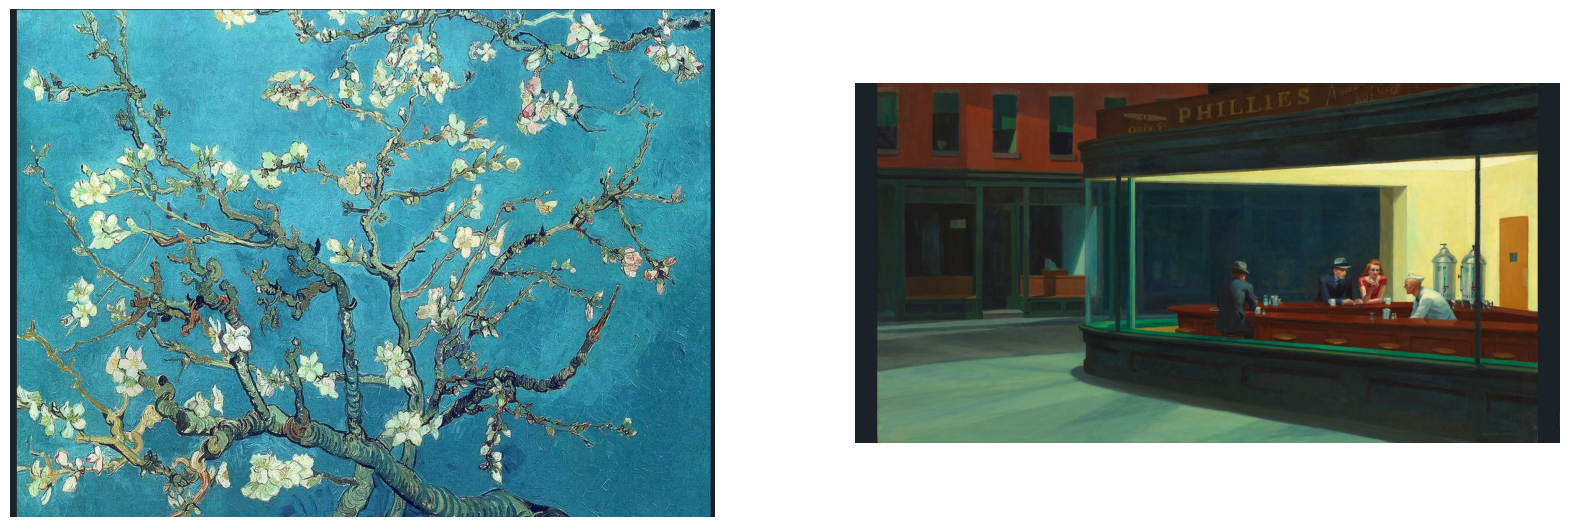

In [4]:
# pick two test images
test_image_1 = np.array(img_1)
test_image_2 = np.array(img_2)

f, axarr = plt.subplots(1,2, figsize=(20,10))
axarr[0].imshow(test_image_1)
axarr[0].axis('off')
axarr[1].imshow(test_image_2)
axarr[1].axis('off')
plt.show()

In [9]:
# get feature vectors and feature maps

feature_vector1, feature_maps1 = da.similarity_methods.dino.get_features(img_1, return_feature_maps=True, resize=True)
feature_vector2, feature_maps2 = da.similarity_methods.dino.get_features(img_2, return_feature_maps=True, resize=True)

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])
Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


(-0.5, 1677.5, 857.5, -0.5)

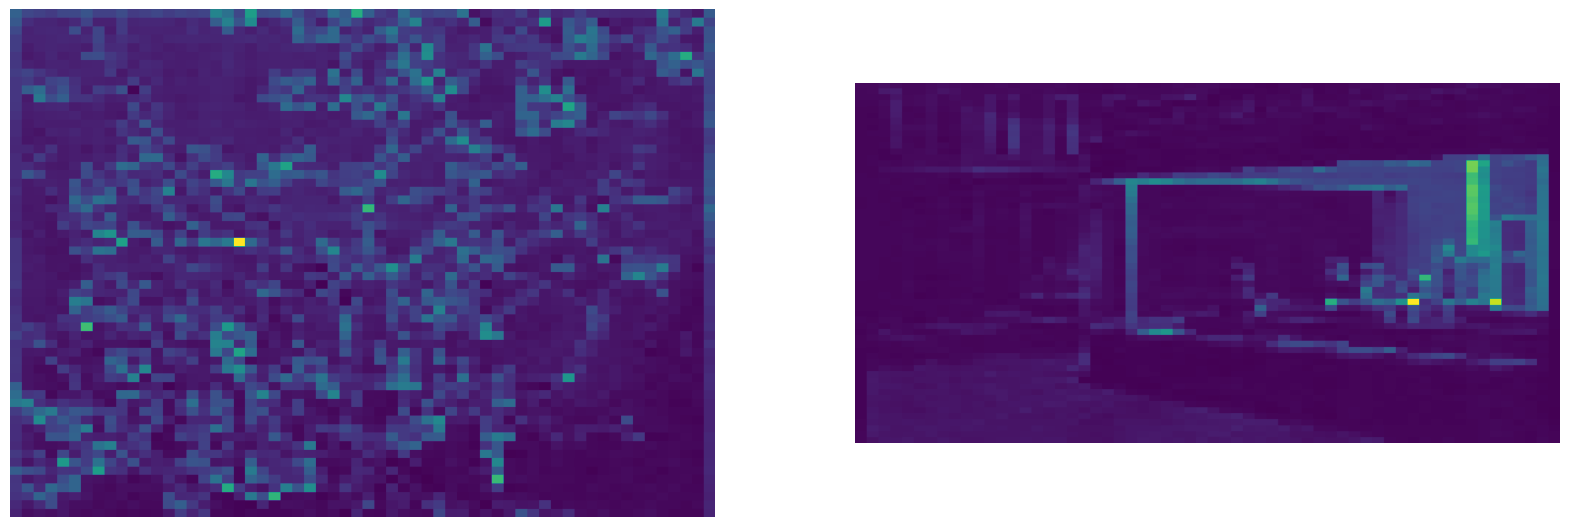

In [10]:
test_head = feature_maps1[2][4]
test_head2 = feature_maps2[2][4]
f, axarr = plt.subplots(1,2, figsize=(20,10))
axarr[0].imshow(test_head)
axarr[0].axis('off')
axarr[1].imshow(test_head2)
axarr[1].axis('off')

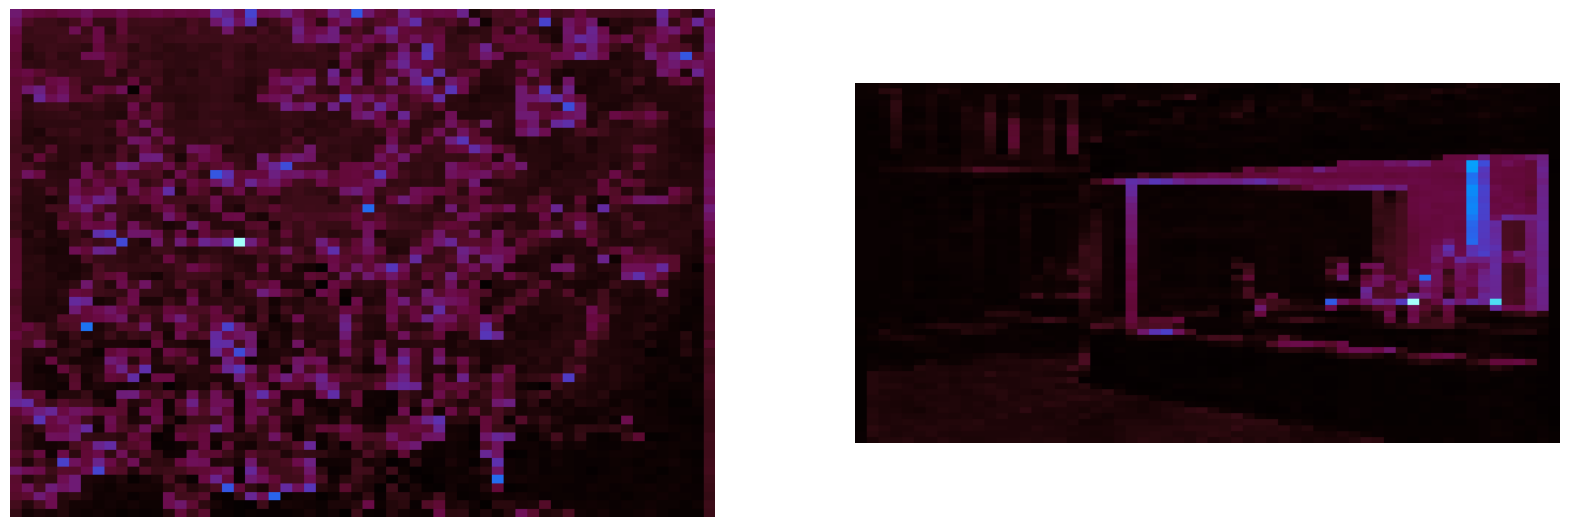

In [11]:
def feature_map_to_colormap(test_head):
    minmaxed = (test_head - test_head.min()) / (test_head.max() - test_head.min())
    minmaxed *= 255
    minmaxed = minmaxed.astype(np.uint8)
    heatmap = cv2.applyColorMap(minmaxed, cv2.COLORMAP_INFERNO)
    return heatmap, minmaxed

heatmap_1, minmaxed_1 = feature_map_to_colormap(test_head)
heatmap_2, minmaxed_2 = feature_map_to_colormap(test_head2)

f, axarr = plt.subplots(1,2, figsize=(20,10))
axarr[0].imshow(heatmap_1)
axarr[0].axis('off')
axarr[1].imshow(heatmap_2)
axarr[1].axis('off')
plt.show()

In [12]:

def overlay_transparent(background, overlay, x, y):
    # taken from https://stackoverflow.com/questions/40895785/using-opencv-to-overlay-transparent-image-onto-another-image

    background_width = background.shape[1]
    background_height = background.shape[0]

    if x >= background_width or y >= background_height:
        return background

    h, w = overlay.shape[0], overlay.shape[1]

    if x + w > background_width:
        w = background_width - x
        overlay = overlay[:, :w]

    if y + h > background_height:
        h = background_height - y
        overlay = overlay[:h]

    if overlay.shape[2] < 4:
        overlay = np.concatenate(
            [
                overlay,
                np.ones((overlay.shape[0], overlay.shape[1], 1), dtype = overlay.dtype) * 255
            ],
            axis = 2,
        )

    overlay_image = overlay[..., :3]
    mask = overlay[..., 3:] / 255.0

    background[y:y+h, x:x+w] = (1.0 - mask) * background[y:y+h, x:x+w] + mask * overlay_image

    return background

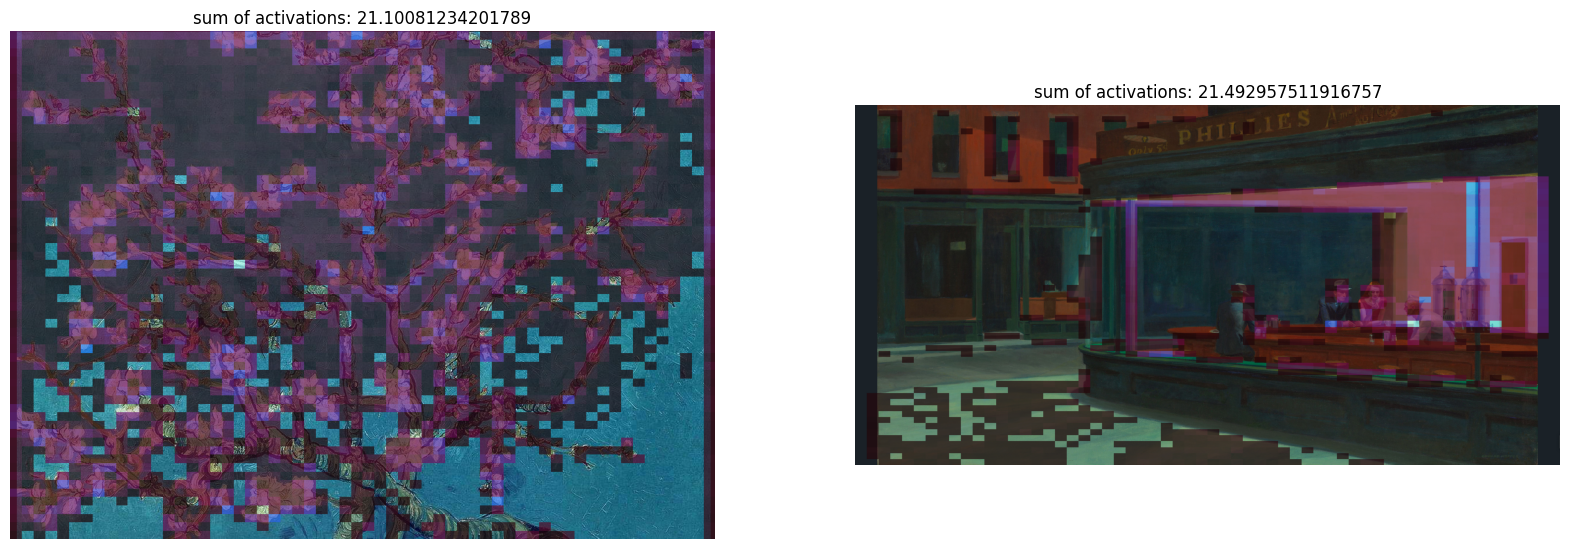

In [33]:
# overlay heatmap on original image for better visibility

def overlay_heatmap(original_image, heatmap, minmaxed, transparancy=0.7, quantile=0.5):

    # add empty alpha channel
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_RGB2RGBA)

    # only take top 50% of probability mass
    mask = np.zeros_like(minmaxed, dtype=np.float32)

    cutoff = np.quantile(minmaxed_1, q=quantile)

    mask[minmaxed >= cutoff] = 1
    mask *= 255

    # make overlay transparant
    mask[mask == 255] *= transparancy
    mask = mask.astype(np.uint8)

    # add alpha channel to heatmap image
    heatmap[:,:, 3] = mask

    # mix heatmap with original image
    overlayed = overlay_transparent(np.array(original_image), heatmap, 0, 0)
    return overlayed

overlayed_1 = overlay_heatmap(img_1, heatmap_1, minmaxed_1, transparancy=0.7, quantile=0.2)
overlayed_2 = overlay_heatmap(img_2, heatmap_2, minmaxed_2, transparancy=0.7, quantile=0.2)

f, axarr = plt.subplots(1,2, figsize=(20,10))
axarr[0].imshow(overlayed_1)
axarr[0].axis('off')
axarr[0].set_title(f"sum of activations: {np.sum(feature_vector1)}")
axarr[1].imshow(overlayed_2)
axarr[1].axis('off')
axarr[1].set_title(f"sum of activations: {np.sum(feature_vector2)}")
plt.show()

In [9]:
from scipy import spatial

distance = spatial.distance.cosine(feature_vector1, feature_vector2)
print(f"cosine distance: {distance}")

cosine distance: 0.018119793221142433


# Clip classification of heads

In [59]:
import torch
import clip
import glob
from tqdm import tqdm
from PIL import Image
import deepsim_analyzer as da

predefined_classes = ['plant', 'face', 'clothing', 'building', 'mountain', 'water', 'metal', 'ship', 'animal', 'sky']
classes_with_prefix = [f"a painting of {category}" for category in predefined_classes]

images = glob.glob("../data/raw_immutable/test_images/*")

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# get text embeddings for each class
tokenized_cwp = clip.tokenize(classes_with_prefix).to(device)

with torch.no_grad():
    text_features = model.encode_text(tokenized_cwp)
    
text_features.shape

torch.Size([10, 512])

In [60]:
def get_topk_similar(image_features, text_features, predefined_classes):
    # Pick the top 5 most similar labels for the image
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    
    # values, indices = similarity[0].topk(5)

    # # Print the result
    # print("\nTop predictions:\n")
    # for value, index in zip(values, indices):
    #     print(f"{predefined_classes[index]:>16s}: {100 * value.item():.2f}%")
    return similarity.cpu().detach().numpy()

In [62]:
clip_score_dict = {}

# 12 layers, with 12 heads each
for layer in range(12):
    for head in range(12):
        clip_score_dict[f"l{layer+1}_h{head+1}"] = []
        
for image_path in tqdm(images, desc='passing feature maps through clip'):

    img = da.io.load_image(image_path, return_np=False)
    
    feature_vector, feature_maps = da.similarity_methods.dino.get_features(img, return_feature_maps=True, resize=True)

    for layer in feature_maps.keys():
        for head in feature_maps[layer].keys():
            
            # if layer != 2:
            #     continue
            # if head != 4:
            #     continue

            # get feature map
            fm = feature_maps[layer][head]

            # mask everything but the highest activating content
            mask = np.zeros_like(fm, dtype=np.float32)
            
            # take top 50% of probability mass
            cutoff = np.quantile(fm, q=0.5)
            mask[fm >= cutoff] = 1

            local_img1 = np.array(img)
            local_img1[mask != 1] = 0

            # make PIL image out of the array
            pil_image = Image.fromarray(local_img1)

            # preprocess with clip
            image = preprocess(pil_image).unsqueeze(0).to(device)

            with torch.no_grad():
                image_features = model.encode_image(image)

            # print("=" * 50)
            # print(f"results for layer {layer}, head {head}: ")
            similarities = get_topk_similar(image_features, text_features, predefined_classes)
            clip_score_dict[f"l{layer+1}_h{head+1}"].append(similarities)


passing feature maps through clip:   0%|          | 0/100 [00:00<?, ?it/s]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:   1%|          | 1/100 [00:07<12:58,  7.86s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:   2%|▏         | 2/100 [00:14<11:54,  7.29s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:   3%|▎         | 3/100 [00:21<11:33,  7.15s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:   4%|▍         | 4/100 [00:29<11:37,  7.26s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:   5%|▌         | 5/100 [00:41<14:31,  9.17s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:   6%|▌         | 6/100 [00:53<15:35,  9.95s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:   7%|▋         | 7/100 [01:03<15:47, 10.18s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:   8%|▊         | 8/100 [01:11<14:24,  9.39s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:   9%|▉         | 9/100 [01:20<13:52,  9.15s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  10%|█         | 10/100 [01:29<14:02,  9.36s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  11%|█         | 11/100 [01:40<14:23,  9.70s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  12%|█▏        | 12/100 [01:49<13:43,  9.35s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  13%|█▎        | 13/100 [01:56<12:49,  8.85s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  14%|█▍        | 14/100 [02:04<12:23,  8.64s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  15%|█▌        | 15/100 [02:12<11:52,  8.38s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  16%|█▌        | 16/100 [02:20<11:40,  8.34s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  17%|█▋        | 17/100 [02:28<11:04,  8.01s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  18%|█▊        | 18/100 [02:35<10:42,  7.83s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  19%|█▉        | 19/100 [02:42<10:08,  7.51s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  20%|██        | 20/100 [02:49<09:48,  7.36s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  21%|██        | 21/100 [02:56<09:42,  7.38s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  22%|██▏       | 22/100 [03:03<09:24,  7.24s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  23%|██▎       | 23/100 [03:10<09:04,  7.07s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  24%|██▍       | 24/100 [03:17<08:52,  7.01s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  25%|██▌       | 25/100 [03:24<08:43,  6.98s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  26%|██▌       | 26/100 [03:30<08:32,  6.92s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  27%|██▋       | 27/100 [03:37<08:24,  6.92s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  28%|██▊       | 28/100 [03:44<08:11,  6.82s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  29%|██▉       | 29/100 [03:51<08:00,  6.76s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  30%|███       | 30/100 [03:58<08:05,  6.94s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  31%|███       | 31/100 [04:05<07:58,  6.93s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  32%|███▏      | 32/100 [04:12<07:49,  6.91s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  33%|███▎      | 33/100 [04:19<07:51,  7.04s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  34%|███▍      | 34/100 [04:26<07:41,  7.00s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  35%|███▌      | 35/100 [04:33<07:33,  6.98s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  36%|███▌      | 36/100 [04:41<07:42,  7.23s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  37%|███▋      | 37/100 [04:48<07:45,  7.39s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  38%|███▊      | 38/100 [05:00<08:55,  8.63s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  39%|███▉      | 39/100 [05:09<08:58,  8.83s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  40%|████      | 40/100 [05:17<08:32,  8.55s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  41%|████      | 41/100 [05:25<08:05,  8.23s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  42%|████▏     | 42/100 [05:34<08:14,  8.53s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  43%|████▎     | 43/100 [05:43<08:10,  8.60s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  44%|████▍     | 44/100 [05:52<08:21,  8.96s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  45%|████▌     | 45/100 [06:01<07:58,  8.71s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  46%|████▌     | 46/100 [06:08<07:31,  8.36s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  47%|████▋     | 47/100 [06:16<07:18,  8.27s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  48%|████▊     | 48/100 [06:26<07:31,  8.68s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  49%|████▉     | 49/100 [06:33<07:03,  8.31s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  50%|█████     | 50/100 [06:42<07:04,  8.50s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  51%|█████     | 51/100 [06:51<06:57,  8.52s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  52%|█████▏    | 52/100 [07:01<07:21,  9.19s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  53%|█████▎    | 53/100 [07:11<07:20,  9.37s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  54%|█████▍    | 54/100 [07:25<08:14, 10.75s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  55%|█████▌    | 55/100 [07:42<09:29, 12.66s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  56%|█████▌    | 56/100 [07:55<09:17, 12.66s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  57%|█████▋    | 57/100 [08:08<09:10, 12.81s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  58%|█████▊    | 58/100 [08:24<09:36, 13.73s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  59%|█████▉    | 59/100 [08:40<09:52, 14.45s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  60%|██████    | 60/100 [08:59<10:36, 15.91s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  61%|██████    | 61/100 [09:15<10:20, 15.91s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  62%|██████▏   | 62/100 [09:32<10:10, 16.06s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  63%|██████▎   | 63/100 [09:50<10:18, 16.72s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  64%|██████▍   | 64/100 [10:01<08:54, 14.86s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  65%|██████▌   | 65/100 [10:16<08:42, 14.94s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  66%|██████▌   | 66/100 [10:33<08:48, 15.53s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  67%|██████▋   | 67/100 [10:44<07:52, 14.31s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  68%|██████▊   | 68/100 [10:53<06:42, 12.57s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  69%|██████▉   | 69/100 [11:00<05:45, 11.16s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  70%|███████   | 70/100 [11:08<04:58,  9.95s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  71%|███████   | 71/100 [11:19<05:00, 10.37s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  72%|███████▏  | 72/100 [11:30<04:53, 10.49s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  73%|███████▎  | 73/100 [11:42<04:56, 11.00s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  74%|███████▍  | 74/100 [11:49<04:12,  9.71s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  75%|███████▌  | 75/100 [12:01<04:20, 10.41s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  76%|███████▌  | 76/100 [12:10<03:59,  9.96s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  77%|███████▋  | 77/100 [12:20<03:55, 10.22s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  78%|███████▊  | 78/100 [12:32<03:54, 10.67s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  79%|███████▉  | 79/100 [12:40<03:26,  9.83s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  80%|████████  | 80/100 [12:49<03:09,  9.47s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  81%|████████  | 81/100 [12:56<02:48,  8.87s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  82%|████████▏ | 82/100 [13:04<02:33,  8.52s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  83%|████████▎ | 83/100 [13:12<02:21,  8.31s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  84%|████████▍ | 84/100 [13:22<02:22,  8.92s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  85%|████████▌ | 85/100 [13:29<02:07,  8.51s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  86%|████████▌ | 86/100 [13:39<02:01,  8.68s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  87%|████████▋ | 87/100 [13:46<01:48,  8.38s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  88%|████████▊ | 88/100 [13:54<01:39,  8.33s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  89%|████████▉ | 89/100 [14:02<01:30,  8.18s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  90%|█████████ | 90/100 [14:10<01:20,  8.07s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  91%|█████████ | 91/100 [14:19<01:14,  8.28s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  92%|█████████▏| 92/100 [14:28<01:07,  8.47s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  93%|█████████▎| 93/100 [14:35<00:57,  8.23s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  94%|█████████▍| 94/100 [14:43<00:47,  7.95s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  95%|█████████▌| 95/100 [14:50<00:39,  7.89s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  96%|█████████▌| 96/100 [14:59<00:32,  8.00s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  97%|█████████▋| 97/100 [15:07<00:24,  8.06s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  98%|█████████▊| 98/100 [15:15<00:16,  8.17s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip:  99%|█████████▉| 99/100 [15:24<00:08,  8.24s/it]

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


passing feature maps through clip: 100%|██████████| 100/100 [15:32<00:00,  9.32s/it]


In [84]:
l1_h1 = np.concatenate(clip_score_dict['l5_h8'] ,axis=0)
mean_clip_scores = np.mean(l1_h1, axis=0)

for i in range(len(predefined_classes)):
    print(f"class: {predefined_classes[i]} has score: {mean_clip_scores[i]}")

class: plant has score: 0.04705810546875
class: face has score: 0.309326171875
class: clothing has score: 0.287353515625
class: building has score: 0.0192718505859375
class: mountain has score: 0.0225372314453125
class: water has score: 0.0256195068359375
class: metal has score: 0.0533447265625
class: ship has score: 0.0582275390625
class: animal has score: 0.1234130859375
class: sky has score: 0.053863525390625
